In [23]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from token import OP
from langchain_huggingface import (
    HuggingFaceEndpointEmbeddings,
    HuggingFaceEndpoint,
    ChatHuggingFace
)
from typing import Optional


def get_hf_llm(model_name: str, model_kwargs: Optional[dict]) -> ChatHuggingFace:

    if not model_kwargs:
        model_kwargs = {
            "max_new_tokens": 1024,
        }
    model = HuggingFaceEndpoint(
        model=model_name,
        **model_kwargs
    )
    return ChatHuggingFace(llm=model)

# test 
llm = get_hf_llm("meta-llama/Llama-3.1-8B-Instruct", model_kwargs={})
llm.invoke("Hi").content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

### Initialize the models to use

**We need to define a configuration dictionary to hold the clients for each of our chosen models. This way we can easily swap models and centralizes our model management.**

In [281]:
# This dictionary will act as our central registry, or "foundry," for all LLM and embedding model clients.
llm_config = {
    # # For the 'planner', we use Llama 3.1 8B. It's a modern, 
    # highly capable model that excels at instruction-following.
    "planner": get_hf_llm(
        model_name="meta-llama/Llama-3.1-8B-Instruct",
        model_kwargs={"temperature": 0.0}
    ),
    # For the 'drafter' and 'sql_coder', we use Qwen2 7B. It's a nimble and fast model, perfect for
    # tasks like text generation and code completion where speed is valuable.
    "drafter": get_hf_llm(
        model_name="Qwen/Qwen3-30B-A3B-Instruct-2507",
        model_kwargs={"temperature": 0.2}
    ),
    "sql_coder": get_hf_llm(
        model_name="Qwen/Qwen3-Coder-30B-A3B-Instruct",
        model_kwargs={"temperature": 0.0}
    ),
    # For the 'director', the highest-level strategic agent, we use the powerful Llama 3 70B model.
    # This high-stakes task of diagnosing performance and evolving the system's own procedures
    # justifies the use of a larger, more powerful model.
    "director": get_hf_llm(
        model_name="meta-llama/Meta-Llama-3-70B-Instruct",
        model_kwargs={"temperature": 0.0}
    ),
    # For embeddings, we use 'Qwen/Qwen3-Embedding-8B",', a top-tier, efficient open-source model.
    "embedding_model": HuggingFaceEndpointEmbeddings(
        model="Qwen/Qwen3-Embedding-8B",
        task="feature-extraction",
    )
}

In [ ]:
# test embedding model
query = "Hey that's a great tutorial."
llm_config["embedding_model"].embed_query(query)

So we have just created our llm_config dictionary, which serves as a centralized hub for all our model initializations. By assigning different models to different roles, we are creating a cost-performance optimized hierarchy.

- **Fast & Nimble (7B-8B models)**: The planner, drafter, and sql_coder roles handle frequent, well-defined tasks. Using smaller models like Qwen2.5 7B and Llama 3.1 8B for these roles ensures low latency and efficient resource usage. They are perfectly capable of following instructions to generate plans, draft text, or write SQL.

- **Deep & Strategic (70B model)**: The director agent has the most complex job, it must analyze multi-dimensional performance data and rewrite the entire system operating procedure. This requires deep reasoning and a understanding of cause and effect. For this high-stakes, low-frequency task, we allocate our most powerful resource, the Llama 3 70B model.

In [282]:
# Print the configuration to confirm the clients are initialized and their parameters are set correctly.
print("LLM clients configured:")
print(f"Planner ({llm_config['planner'].model_id}): {llm_config['planner']}")
print(f"Drafter ({llm_config['drafter'].model_id}): {llm_config['drafter']}")
print(f"SQL Coder ({llm_config['sql_coder'].model_id}): {llm_config['sql_coder']}")
print(f"Director ({llm_config['director'].model_id}): {llm_config['director']}")
print(f"Embedding Model ({llm_config['embedding_model'].model}): {llm_config['embedding_model']}")

LLM clients configured:
Planner (meta-llama/Llama-3.1-8B-Instruct): llm=HuggingFaceEndpoint(temperature=0.0, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='meta-llama/Llama-3.1-8B-Instruct', client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, async_client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>) model_id='meta-llama/Llama-3.1-8B-Instruct' top_p=0.95 max_tokens=512 model_kwargs={}
Drafter (Qwen/Qwen3-30B-A3B-Instruct-2507): llm=HuggingFaceEndpoint(temperature=0.2, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='Qwen/Qwen3-30B-A3B-Instruct-2507', client=<InferenceClient(model='Qwen/Qwen3-30B-A3B-Instruct-2507', timeout=120)>, async_client=<InferenceClient(model='Qwen/Qwen3-30B-A3B-Instruct-2507', timeout=120)>) model_id='Qwen/Qwen3-30B-A3B-Instruct-2507' temperature=0.2 top_p=0.95 max_tokens=512 model_kwargs={}
SQL Coder (Qwen/Qwen3-Coder-30B-A3B-Instruct): llm=HuggingFaceEndpoint(temperature=0.0, st

### Preparing the Knowledge Stores

The most important part for a RAG pipeline is a rich multi-modal knowledge base to draw upon. A generic, web-based search is not enough for a specialized task like clinical trial design. We need to ground our agents in authoritative, domain-specific information.

In [22]:
import os

# A dictionary to hold the paths for our different data types. This keeps our file management clean and centralized.
data_paths = {
    "base": "./data",
    "pubmed": "./data/pubmed_articles",
    "fda": "./data/fda_guidelines",
    "ethics": "./data/ethical_guidelines",
    "mimic": "./data/mimic_db"
}
# This loop iterates through our defined paths and uses os.makedirs() to create any directories that don't already exist.
# This prevents errors in later steps when we try to save files to these locations.
for path in data_paths.values():
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")

Created directory: ./data
Created directory: ./data/pubmed_articles
Created directory: ./data/fda_guidelines
Created directory: ./data/ethical_guidelines
Created directory: ./data/mimic_db


Download Pubmed articles for our medical researcher

In [24]:
from Bio import Entrez
from Bio import Medline

def download_pubmed_articles(query, max_articles=20):
    """Fetches abstracts from PubMed for a given query and saves them as text files."""
    # The NCBI API requires an email address for identification. We fetch it from our environment variables.
    Entrez.email = os.environ.get("ENTREZ_EMAIL")
    print(f"Fetching PubMed articles for query: {query}")
    
    # Step 1: Use Entrez.esearch to find the PubMed IDs (PMIDs) for articles matching our query.
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_articles, sort="relevance")
    record = Entrez.read(handle)
    id_list = record["IdList"]
    print(f"Found {len(id_list)} article IDs.")
    
    print("Downloading articles...")
    # Step 2: Use Entrez.efetch to retrieve the full records (in MEDLINE format) for the list of PMIDs.
    handle = Entrez.efetch(db="pubmed", id=id_list, rettype="medline", retmode="text")
    records = Medline.parse(handle)
    
    count = 0
    # Step 3: Iterate through the retrieved records, parse them, and save each abstract to a file.
    for i, record in enumerate(records):
        pmid = record.get("PMID", "")
        title = record.get("TI", "No Title")
        abstract = record.get("AB", "No Abstract")
        if pmid:
            # We name the file after the PMID for easy reference and to avoid duplicates.
            filepath = os.path.join(data_paths["pubmed"], f"{pmid}.txt")
            with open(filepath, "w") as f:
                f.write(f"Title: {title}\n\nAbstract: {abstract}")
            print(f"[{i+1}/{len(id_list)}] Fetching PMID: {pmid}... Saved to {filepath}")
            count += 1
    return count

In [25]:
# We define a specific, boolean query to find articles highly relevant to our trial concept.
pubmed_query = "(SGLT2 inhibitor) AND (type 2 diabetes) AND (renal impairment)"
num_downloaded = download_pubmed_articles(pubmed_query)
print(f"PubMed download complete. {num_downloaded} articles saved.")

Fetching PubMed articles for query: (SGLT2 inhibitor) AND (type 2 diabetes) AND (renal impairment)
Found 20 article IDs.
[1/20] Fetching PMID: 36945734... Saved to ./data/pubmed_articles/36945734.txt
[2/20] Fetching PMID: 40470996... Saved to ./data/pubmed_articles/40470996.txt
[3/20] Fetching PMID: 38914124... Saved to ./data/pubmed_articles/38914124.txt
[4/20] Fetching PMID: 30697905... Saved to ./data/pubmed_articles/30697905.txt
[5/20] Fetching PMID: 36335326... Saved to ./data/pubmed_articles/36335326.txt
[6/20] Fetching PMID: 36351458... Saved to ./data/pubmed_articles/36351458.txt
[7/20] Fetching PMID: 40327845... Saved to ./data/pubmed_articles/40327845.txt
[8/20] Fetching PMID: 35113333... Saved to ./data/pubmed_articles/35113333.txt
[9/20] Fetching PMID: 34619106... Saved to ./data/pubmed_articles/34619106.txt
[10/20] Fetching PMID: 33413348... Saved to ./data/pubmed_articles/33413348.txt
[11/20] Fetching PMID: 34272327... Saved to ./data/pubmed_articles/34272327.txt
[12/20] 

Now, let’s get the regulatory documents that our Regulatory Specialist agent will need. A key part of trial design is ensuring compliance with government guidelines.

In [82]:
from os import read
import requests
from pypdf import PdfReader
import io

def download_and_extract_text_from_pdf(url, output_path, download=False):
    """Downloads a PDF from a URL, saves it, and also extracts its text content to a separate .txt file."""
    print(f"Downloading FDA Guideline: {url}")
    try:
        # We use the 'requests' library to perform the HTTP GET request to download the file.
        if download:
            response = requests.get(url)
            response.raise_for_status() # This is a good practice that will raise an error if the download fails (e.g., a 404 error).
        
            # We save the raw PDF file, which is useful for archival purposes.
            with open(output_path, 'wb') as f:
                f.write(response.content)
            print(f"Successfully downloaded and saved to {output_path}")
        
            # We then use pypdf to read the PDF content directly from the in-memory response.
            reader = PdfReader(io.BytesIO(response.content))
        else:
            reader = PdfReader(output_path)
        text = ""
        # We loop through each page of the PDF and append its extracted text.
        for page in reader.pages:
            text += page.extract_text() + "\n\n"
        
        # Finally, we save the clean, extracted text to a .txt file. This is the file our RAG system will actually use.
        txt_output_path = os.path.splitext(output_path)[0] + '.txt'
        with open(txt_output_path, 'w') as f:
            f.write(text)
        return True
    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        return False

This function, download_and_extract_text_from_pdf, is our tool for handling PDF documents. It's a two-stage process.

- First, it downloads and saves the original PDF from the FDA website. Second, and more importantly, it immediately processes that PDF using pypdf to extract all the text content.

- It then saves this raw text to a .txt file. This pre-processing step is crucial because it converts the complex PDF format into simple text that our document loaders can easily ingest when we build our vector stores later on.

Let’s run the function to download our FDA guidance document.

In [ ]:
# This URL points to a real FDA guidance document for developing drugs for diabetes.
fda_url = "https://www.fda.gov/media/71185/download"
fda_pdf_path = os.path.join(data_paths["fda"], "fda_diabetes_guidance_ocr.pdf")
download_and_extract_text_from_pdf(fda_url, fda_pdf_path)

True

Instructions for ethics specialist

In [84]:
# This multi-line string contains a curated summary of the three core principles of the Belmont Report,
# which is the foundational document for ethics in human subject research in the United States.
ethics_content = """
Title: Summary of the Belmont Report Principles for Clinical Research
1. Respect for Persons: This principle requires that individuals be treated as autonomous agents and that persons with diminished autonomy are entitled to protection. This translates to robust informed consent processes. Inclusion/exclusion criteria must not unduly target or coerce vulnerable populations, such as economically disadvantaged individuals, prisoners, or those with severe cognitive impairments, unless the research is directly intended to benefit that population.
2. Beneficence: This principle involves two complementary rules: (1) do not harm and (2) maximize possible benefits and minimize possible harms. The criteria must be designed to select a population that is most likely to benefit and least likely to be harmed by the intervention. The risks to subjects must be reasonable in relation to anticipated benefits.
3. Justice: This principle concerns the fairness of distribution of the burdens and benefits of research. The selection of research subjects must be equitable. Criteria should not be designed to exclude certain groups without a sound scientific or safety-related justification. For example, excluding participants based on race, gender, or socioeconomic status is unjust unless there is a clear rationale related to the drug's mechanism or risk profile.
"""

# We define the path where our ethics document will be saved.
ethics_path = os.path.join(data_paths["ethics"], "belmont_summary.txt")

# We open the file in write mode and save the content.
with open(ethics_path, "w") as f:
    f.write(ethics_content)
print(f"Created ethics guideline file: {ethics_path}")

Created ethics guideline file: ./data/ethical_guidelines/belmont_summary.txt


Now for our most complex data source: the structured clinical data from MIMIC-III. This will provide the real-world population data our Patient Cohort Analyst needs to assess recruitment feasibility.

In [226]:
import duckdb
import pandas as pd
import os


def load_real_mimic_data():
    """Loads real MIMIC-III CSVs into a persistent DuckDB database file, processing the massive LABEVENTS table efficiently."""
    print("Attempting to load real MIMIC-III data from local CSVs...")
    db_path = os.path.join(data_paths["mimic"], "mimic3_real.db")
    csv_dir = os.path.join(data_paths["mimic"], "mimiciii_csvs")
    
    # Define the paths to the required compressed CSV files.
    required_files = {
        "patients": os.path.join(csv_dir, "PATIENTS.csv"),
        "diagnoses": os.path.join(csv_dir, "DIAGNOSES_ICD.csv"),
        "labevents": os.path.join(csv_dir, "LABEVENTS.csv"),
    }
    
    # Before starting, we check if all the necessary source files are present.
    missing_files = [path for path in required_files.values() if not os.path.exists(path)]
    if missing_files:
        print("ERROR: The following MIMIC-III files were not found:")
        for f in missing_files: print(f"- {f}")
        print("\nPlease download them as instructed and place them in the correct directory.")
        return None
    
    print("Required files found. Proceeding with database creation.")
    # Remove any old database file to ensure we are building from scratch.
    if os.path.exists(db_path):
        os.remove(db_path)
    # Connect to DuckDB. If the database file doesn't exist, it will be created.
    con = duckdb.connect(db_path)
    
    # Use DuckDB's powerful `read_csv_auto` to directly load data from the gzipped CSVs into SQL tables.
    print(f"Loading {required_files['patients']} into DuckDB...")
    con.execute("DROP TABLE IF EXISTS patients")
    con.execute(f"CREATE TABLE patients AS SELECT SUBJECT_ID, GENDER, DOB, DOD FROM read_csv_auto('{required_files['patients']}')")
    
    print(f"Loading {required_files['diagnoses']} into DuckDB...")
    con.execute(f"CREATE TABLE diagnoses_icd AS SELECT SUBJECT_ID, ICD9_CODE FROM read_csv_auto('{required_files['diagnoses']}')")
    
    # The LABEVENTS table is enormous. To handle it robustly, we use a two-stage process.
    print(f"Loading and processing {required_files['labevents']} (this may take several minutes)...")
    # 1. Load the data into a temporary 'staging' table, treating all columns as text (`all_varchar=True`).
    #    This prevents parsing errors with mixed data types. We also filter for only the lab item IDs we
    #    care about (50912 for Creatinine, 50852 for HbA1c) and use a regex to ensure VALUENUM is numeric.
    con.execute(f"""CREATE TABLE labevents_staging AS 
                   SELECT SUBJECT_ID, ITEMID, VALUENUM 
                   FROM read_csv_auto('{required_files['labevents']}', all_varchar=True) 
                   WHERE ITEMID IN ('50912', '50852') AND VALUENUM IS NOT NULL AND VALUENUM ~ '^[0-9]+(\\.[0-9]+)?$'
                """)
    # 2. Create the final, clean table by selecting from the staging table and casting the columns to their correct numeric types.
    con.execute("CREATE TABLE labevents AS SELECT SUBJECT_ID, CAST(ITEMID AS INTEGER) AS ITEMID, CAST(VALUENUM AS DOUBLE) AS VALUENUM FROM labevents_staging")
    # 3. Drop the temporary staging table to save space.
    con.execute("DROP TABLE labevents_staging")
    con.close()
    return db_path

Instead of trying to load the massive MIMIC-III CSV files into memory with pandas (which would likely crash), we are usingDuckDB ability to process data directly from disk. The two-stage processing of theLABEVENTS table is a critical technique. By first loading the data as text and filtering it before casting to numeric types, before this we handle data quality issues and create a final table that is smaller, cleaner, and much faster to query.

In [232]:
# Execute the function to build the database.
db_path = load_real_mimic_data()

# If the database was created successfully, connect to it and inspect the schema and some sample data.
if db_path:
    print(f"\nReal MIMIC-III database created at: {db_path}")
    print("\nTesting database connection and schema...")
    con = duckdb.connect(db_path)
    print(f"Tables in DB: {con.execute('SHOW TABLES').df()['name'].tolist()}")
    print("\nSample of 'patients' table:")
    print(con.execute("SELECT * FROM patients LIMIT 5").df())
    print("\nSample of 'diagnoses_icd' table:")
    print(con.execute("SELECT * FROM diagnoses_icd LIMIT 5").df())
    con.close()

Attempting to load real MIMIC-III data from local CSVs...
Required files found. Proceeding with database creation.
Loading ./data/mimic_db/mimiciii_csvs/PATIENTS.csv into DuckDB...
Loading ./data/mimic_db/mimiciii_csvs/DIAGNOSES_ICD.csv into DuckDB...
Loading and processing ./data/mimic_db/mimiciii_csvs/LABEVENTS.csv (this may take several minutes)...

Real MIMIC-III database created at: ./data/mimic_db/mimic3_real.db

Testing database connection and schema...
Tables in DB: ['diagnoses_icd', 'labevents', 'patients']

Sample of 'patients' table:
   subject_id gender        dob        dod
0       10006      F 2094-03-05 2165-08-12
1       10011      F 2090-06-05 2126-08-28
2       10013      F 2038-09-03 2125-10-07
3       10017      F 2075-09-21 2152-09-12
4       10019      M 2114-06-20 2163-05-15

Sample of 'diagnoses_icd' table:
   subject_id icd9_code
0       10006     99591
1       10006     99662
2       10006      5672
3       10006     40391
4       10006     42731


In [236]:
con = duckdb.connect(db_path)
# print(con.execute('SHOW TABLES').df()['name'].tolist())
print(con.execute("SELECT * FROM patients LIMIT 5").df())
con.close()

   subject_id gender        dob        dod
0       10006      F 2094-03-05 2165-08-12
1       10011      F 2090-06-05 2126-08-28
2       10013      F 2038-09-03 2125-10-07
3       10017      F 2075-09-21 2152-09-12
4       10019      M 2114-06-20 2163-05-15


Our Patient Cohort Analyst agent now has access to a high-performance, real-world clinical database containing millions of records, enabling it to provide truly data-grounded feasibility estimates.


Finally, let’s index all our unstructured text data into searchable vector stores. This will make the PubMed, FDA, and ethics documents accessible to our RAG agents.

In [97]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from torch import chunk

def create_vector_store(folder_path: str, embedding_model: HuggingFaceEndpointEmbeddings, store_name: str):
    """Loads all .txt files from a folder, splits them into chunks, and creates an in-memory FAISS vector store."""
    loader = DirectoryLoader(
        path=folder_path,
        glob="**/*.txt",
        show_progress=True,
        loader_cls=TextLoader,
    )
    documents = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    texts = text_splitter.split_documents(documents=documents)
    db = FAISS.from_documents(texts, embedding=embedding_model)
    print(f"{store_name} Vector Store created successfully.")
    return db


def create_retrievers(embedding_model: HuggingFaceEndpointEmbeddings):
    """Creates vector store retrievers for all unstructured data sources and consolidates all knowledge stores."""
    # Create a separate, specialized vector store for each type of document.
    pubmed_db = create_vector_store(data_paths["pubmed"], embedding_model, "PubMed")
    fda_db = create_vector_store(data_paths["fda"], embedding_model, "FDA")
    ethics_db = create_vector_store(data_paths["ethics"], embedding_model, "Ethics")
    
    # Return a single dictionary containing all configured data access tools.
    # The 'as_retriever' method converts the vector store into a standard LangChain Retriever object.
    # The 'k' parameter in 'search_kwargs' controls how many top documents are returned by a search.
    return {
        "pubmed_retriever": pubmed_db.as_retriever(search_kwargs={"k": 3}) if pubmed_db else None,
        "fda_retriever": fda_db.as_retriever(search_kwargs={"k": 3}) if fda_db else None,
        "ethics_retriever": ethics_db.as_retriever(search_kwargs={"k": 2}) if ethics_db else None,
        "mimic_db_path": db_path # We also include the file path to our structured DuckDB database.
    }

In [98]:
# Execute the function to create all our retrievers.
knowledge_stores = create_retrievers(llm_config["embedding_model"])

print("\nKnowledge stores and retrievers created successfully.")

# Print the final dictionary to confirm all components are present.
for name, store in knowledge_stores.items():
    print(f"{name}: {store}")

100%|██████████| 20/20 [00:00<00:00, 2676.39it/s]


PubMed Vector Store created successfully.


100%|██████████| 1/1 [00:00<00:00, 1748.36it/s]


FDA Vector Store created successfully.


100%|██████████| 1/1 [00:00<00:00, 842.57it/s]


Ethics Vector Store created successfully.

Knowledge stores and retrievers created successfully.
pubmed_retriever: tags=['FAISS', 'HuggingFaceEndpointEmbeddings'] vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x1486f97f0> search_kwargs={'k': 3}
fda_retriever: tags=['FAISS', 'HuggingFaceEndpointEmbeddings'] vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x12c7ea0c0> search_kwargs={'k': 3}
ethics_retriever: tags=['FAISS', 'HuggingFaceEndpointEmbeddings'] vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x1486f9850> search_kwargs={'k': 2}
mimic_db_path: ./data/mimic_db/mimic3_real.db


### Building The Inner Trial Design Network

With our knowledge base is now ready, we can now construct the core of our system. This is not going to be a simple, linear RAG chain. It is a collaborative, multi-agent workflow built with LangGraph, where a team of AI specialists works together to transform a high-level trial concept into a detailed, data-grounded criteria document.

In [283]:
from pydantic import BaseModel, Field
from typing import Literal

class GuildSOP(BaseModel):
    """Standard Operating Procedures for the Trial Design Guild. This object acts as the dynamic configuration for the entire RAG workflow."""
    
    # This field holds the system prompt for the Planner Agent, dictating its strategy.
    planner_prompt: str = Field(description="The system prompt for the Planner Agent.")
    
    # This parameter controls how many documents the Medical Researcher retrieves, allowing us to tune the breadth of its search.
    researcher_retriever_k: int = Field(description="Number of documents for the Medical Researcher to retrieve.", default=3)
    
    # This is the system prompt for the final writer, the Synthesizer Agent.
    synthesizer_prompt: str = Field(description="The system prompt for the Criteria Synthesizer Agent.")
    
    # This allows us to dynamically change the model used for the final drafting stage, trading off speed vs. quality.
    synthesizer_model: Literal["Qwen/Qwen2.5-7B-Instruct", "meta-llama/Llama-3.1-8B-Instruct", "Qwen/Qwen3-30B-A3B-Instruct-2507"] = Field(
        description="The LLM to use for the Synthesizer.", 
        default="Qwen/Qwen3-30B-A3B-Instruct-2507"
    )
    
    # These booleans act as "feature flags," allowing the Director to turn entire agent capabilities on or off.
    use_sql_analyst: bool = Field(description="Whether to use the Patient Cohort Analyst agent.", default=True)
    use_ethics_specialist: bool = Field(description="Whether to use the Ethics Specialist agent.", default=True)

Now that we have the blueprint for our SOP, let’s create a concrete, version 1.0 instance. This baseline_sop will be our starting point, the initial, hand-engineered strategy that we will task our AI Director with improving.

In [284]:
import json

# We instantiate our GuildSOP class with a set of default, baseline values.
baseline_sop = GuildSOP(
    # The initial planner prompt is very detailed, instructing the agent on its role, the specialists available, and the required JSON output format.
    planner_prompt="""You are a master planner for clinical trial design. Your task is to receive a high-level trial concept and break it down into a structured plan with specific sub-tasks for a team of specialists: a Regulatory Specialist, a Medical Researcher, an Ethics Specialist, and a Patient Cohort Analyst. Output a JSON object with a single key 'plan' containing a list of tasks. Each task must have 'agent', 'task_description', and 'dependencies' keys.""",
    
    # The synthesizer prompt instructs the final writer on how to structure the output document.
    synthesizer_prompt="""You are an expert medical writer. Your task is to synthesize the structured findings from all specialist teams into a formal 'Inclusion and Exclusion Criteria' document. Be concise, precise, and adhere strictly to the information provided. Structure your output into two sections: 'Inclusion Criteria' and 'Exclusion Criteria'.""",
    
    # We'll start with a default retrieval of 3 documents for the researcher.
    researcher_retriever_k=3,
    
    # We'll use the fast qwen2:7b model for the synthesizer initially.
    synthesizer_model="Qwen/Qwen3-30B-A3B-Instruct-2507",
    
    # By default, we'll use all our specialist agents.
    use_sql_analyst=True,
    use_ethics_specialist=True
)

In [285]:
print("Baseline GuildSOP (v1.0):")
# We use .dict() to convert the Pydantic model to a dictionary and json.dumps for clean printing.
print(json.dumps(baseline_sop.model_dump(), indent=4))

Baseline GuildSOP (v1.0):
{
    "planner_prompt": "You are a master planner for clinical trial design. Your task is to receive a high-level trial concept and break it down into a structured plan with specific sub-tasks for a team of specialists: a Regulatory Specialist, a Medical Researcher, an Ethics Specialist, and a Patient Cohort Analyst. Output a JSON object with a single key 'plan' containing a list of tasks. Each task must have 'agent', 'task_description', and 'dependencies' keys.",
    "researcher_retriever_k": 3,
    "synthesizer_prompt": "You are an expert medical writer. Your task is to synthesize the structured findings from all specialist teams into a formal 'Inclusion and Exclusion Criteria' document. Be concise, precise, and adhere strictly to the information provided. Structure your output into two sections: 'Inclusion Criteria' and 'Exclusion Criteria'.",
    "synthesizer_model": "Qwen/Qwen3-30B-A3B-Instruct-2507",
    "use_sql_analyst": true,
    "use_ethics_specialis

### Defining the Specialist Agents

Now that we have the rulebook (the SOP), we need to define the agents themselves. In LangGraph, agents are represented as nodes, which are simply Python functions that take the current graph state as input and return an update to that state.

In [286]:
from typing import List, Dict, Any, Optional
from pydantic import BaseModel
from typing_extensions import TypedDict

# We first define a structure for a single agent's output.
# This ensures every agent's findings are packaged consistently with clear attribution.
class AgentOutput(BaseModel):
    """A structured output for each agent's findings."""
    agent_name: str
    findings: Any

# Now we define the main state for the entire Guild workflow.
class GuildState(TypedDict):
    """The state of the Trial Design Guild's workflow, passed between all nodes."""
    initial_request: str                   # The user's initial high-level trial concept.
    plan: Optional[Dict[str, Any]]         # The structured plan generated by the Planner.
    agent_outputs: List[AgentOutput]       # An accumulating list of findings from each specialist.
    final_criteria: Optional[str]          # The final, synthesized document.
    sop: GuildSOP                          # The dynamic SOP for this specific run.

### Multi-agent framework

<p align="center">
  <img src="../figures/medical_agent_arch.webp" width="1200">
</p>

### Planner agent

In [287]:
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.prompts import ChatPromptTemplate


class PlannerOutput(BaseModel):
    plan: List = Field(..., description="The plan to follow.")


def planner_agent(state: GuildState) -> GuildState:
    """Receives the initial request and creates a structured plan for the specialist agents."""
    print("--- EXECUTING PLANNER AGENT ---")

    # Retrieve the current SOP from the state. This allows its behavior to be dynamic.
    sop = state['sop']

    # Configure the 'planner' LLM to expect a JSON output that matches the schema {'plan': []}.
    planner_llm = llm_config['planner']  # with_structured_output(schema={"plan": []})

    output_parser = JsonOutputParser(
        name="research_parser",
        pydantic_object=PlannerOutput
    )
    
    # Construct the full prompt by combining the generic prompt from the SOP with the specific trial concept for this run.
    template = """{planner_prompt}\n\nTrial Concept: '{initial_request}'\n\n{format_instructions}"""

    prompt = ChatPromptTemplate.from_template(
        template=template,
        partial_variables={"format_instructions":output_parser.get_format_instructions()}
    )
    # print(f"Planner Prompt:\n{prompt}")

    research_chain = prompt | planner_llm | output_parser
    
    # # Invoke the LLM to generate the plan.
    response = research_chain.invoke({
        "planner_prompt": sop["planner_prompt"] if isinstance(sop, dict) else sop.planner_prompt,
        "initial_request": state["initial_request"]
    })
    print(f"Generated Plan:\n{json.dumps(response, indent=2)}")
    
    # Return an update to the state, adding the newly generated plan.
    return {**state, "plan": response}

In [258]:
# Testing

# This is our high-level request, the initial spark for the entire workflow.
test_request = "Draft inclusion/exclusion criteria for a Phase II trial of 'Sotagliflozin', a novel SGLT2 inhibitor, for adults with uncontrolled Type 2 Diabetes (HbA1c > 8.0%) and moderate chronic kidney disease (CKD Stage 3)."

print("Running the full Guild graph with baseline SOP v1.0...")
# We prepare the initial state for the graph, providing the request and our baseline SOP.
graph_input = {
    "initial_request": test_request,
    "sop": baseline_sop
}

planner_agent(graph_input)

Running the full Guild graph with baseline SOP v1.0...
--- EXECUTING PLANNER AGENT ---
Planner Prompt:
input_variables=['initial_request', 'planner_prompt'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['initial_request', 'planner_prompt'], input_types={}, partial_variables={'format_instructions': 'STRICT OUTPUT FORMAT:\n- Return only the JSON value that conforms to the schema. Do not include any additional text, explanations, headings, or separators.\n- Do not wrap the JSON in Markdown or code fences (no ``` or ```json).\n- Do not prepend or append any text (e.g., do not write "Here is the JSON:").\n- The response must be a single top-level JSON value exactly as required by the schema (object/array/etc.), with no trailing commas or comments.\n\nThe output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": 

{'initial_request': "Draft inclusion/exclusion criteria for a Phase II trial of 'Sotagliflozin', a novel SGLT2 inhibitor, for adults with uncontrolled Type 2 Diabetes (HbA1c > 8.0%) and moderate chronic kidney disease (CKD Stage 3).",
 'sop': GuildSOP(planner_prompt="You are a master planner for clinical trial design. Your task is to receive a high-level trial concept and break it down into a structured plan with specific sub-tasks for a team of specialists: a Regulatory Specialist, a Medical Researcher, an Ethics Specialist, and a Patient Cohort Analyst. Output a JSON object with a single key 'plan' containing a list of tasks. Each task must have 'agent', 'task_description', and 'dependencies' keys.", researcher_retriever_k=3, synthesizer_prompt="You are an expert medical writer. Your task is to synthesize the structured findings from all specialist teams into a formal 'Inclusion and Exclusion Criteria' document. Be concise, precise, and adhere strictly to the information provided. St

We now need to build the specialist agents that will execute its plan. To avoid writing repetitive code, we’ll start by creating a generic, reusable function for all our RAG-based specialists (the Medical Researcher, Regulatory Specialist, and Ethics Specialist).

In [288]:
def retrieval_agent(task_description: str, state: GuildState, retriever_name: str, agent_name: str) -> AgentOutput:
    """A generic agent function that performs retrieval from a specified vector store based on a task description."""
    print(f"--- EXECUTING {agent_name.upper()} ---")
    print(f"Task: {task_description}")
    
    # Select the correct retriever from our global 'knowledge_stores' dictionary.
    retriever = knowledge_stores[retriever_name]
    
    # This is a key dynamic feature: if the agent is the Medical Researcher,
    # we override its 'k' value (number of documents to retrieve) with the value from the current SOP.
    if agent_name == "Medical Researcher":
        retriever.search_kwargs['k'] = state['sop'].researcher_retriever_k
        print(f"Using k={state['sop'].researcher_retriever_k} for retrieval.")

    # Invoke the retriever with the task description to find relevant documents.
    retrieved_docs = retriever.invoke(task_description)
    
    # Format the findings into a clean string, including the source of each document for traceability.
    findings = "\n\n---\n\n".join([f"Source: {doc.metadata.get('source', 'N/A')}\n\n{doc.page_content}" for doc in retrieved_docs])
    print(f"Retrieved {len(retrieved_docs)} documents.")
    print(f"Sample Finding:\n{findings[:500]}...")
    
    # Return the findings in our standardized AgentOutput format.
    return AgentOutput(agent_name=agent_name, findings=findings)

Specifically checks if it's acting as the Medical Researcher and, if so, adjusts its retrieval parameter k based on the value in state['sop'].researcher_retriever_k. This makes the thoroughness of the literature search a dynamically tunable parameter that our AI Director can evolve.

Now, let’s build our most technically complex specialist: the Patient Cohort Analyst. This agent will bridge the gap between unstructured RAG and structured data analytics. It will take a natural language request, use an LLM to translate it into a valid SQL query, and then execute that query against our DuckDB database of MIMIC-III data to provide a data-grounded feasibility estimate.

In [289]:
def patient_cohort_analyst(task_description: str, state: GuildState) -> AgentOutput:
    """Estimates cohort size by generating and then executing a SQL query against the MIMIC database."""
    print("--- EXECUTING PATIENT COHORT ANALYST ---")
    
    # This is a feature flag. We first check the SOP to see if this agent should even run.
    if not state['sop'].use_sql_analyst:
        print("SQL Analyst skipped as per SOP.")
        return AgentOutput(agent_name="Patient Cohort Analyst", findings="Analysis skipped as per SOP.")
    
    # For the LLM to write correct SQL, it needs to know the database schema.
    # We connect to DuckDB and query the information_schema to get table and column names.
    con = duckdb.connect(knowledge_stores['mimic_db_path'])
    schema_query = """
    SELECT table_name, column_name, data_type 
    FROM information_schema.columns 
    WHERE table_schema = 'main' ORDER BY table_name, column_name;
    """
    schema = con.execute(schema_query).df()
    con.close()
    
    # We create a highly detailed prompt for our SQL-writing LLM.
    # It includes the schema and, crucially, specific instructions on how to map medical concepts to ICD9 codes or lab values.
    sql_generation_prompt = ChatPromptTemplate.from_messages([
    ("system", f"""You are an expert SQL writer specializing in DuckDB. Your task is to only write a single, valid SQL query to count unique patients based on a request. The database contains MIMIC-III patient data with the following schema:
{schema.to_string()}

IMPORTANT RULES:
- All column names in your query MUST be uppercase (e.g., SELECT SUBJECT_ID, ICD9_CODE...).
- ALWAYS cast SUBJECT_ID to the same type when comparing across tables. Use CAST(SUBJECT_ID AS BIGINT) or CAST(SUBJECT_ID AS VARCHAR) to ensure type consistency.
- Prefer using JOINs instead of subqueries with IN clause for better type handling.

Key Mappings:
- T2DM (Type 2 Diabetes) corresponds to ICD9_CODE '25000'.
- Moderate renal impairment can be estimated by a creatinine lab value (ITEMID 50912) where VALUENUM is between 1.5 and 3.0.
- Uncontrolled T2D can be estimated by an HbA1c lab value (ITEMID 50852) where VALUENUM is greater than 8.0.

Enclose the sql code in ```sql<sql_code>``` and do not include any text."""),
    ("human", "Please write a SQL query to count the number of unique patients who meet the following criteria: {task} \n\n Respond with ONLY the SQL query, nothing else.")
])
    
    # We create a simple chain to generate the SQL query.
    sql_chain = sql_generation_prompt | llm_config['sql_coder'] | StrOutputParser()
    
    print(f"Generating SQL for task: {task_description}")
    sql_query = sql_chain.invoke({"task": task_description})
    # The LLM might wrap the query in markdown, so we clean it up.
    sql_query = sql_query.strip().replace("```sql", "").replace("```", "")
    print(f"Generated SQL Query:\n{sql_query}")
    try:
        # We now execute the generated query against the real DuckDB database.
        con = duckdb.connect(knowledge_stores['mimic_db_path'])
        result = con.execute(sql_query).fetchone()
        patient_count = result[0] if result else 0
        con.close()
        
        # We package the findings, including the query itself for transparency.
        findings = f"Generated SQL Query:\n{sql_query}\n\nEstimated eligible patient count from the database: {patient_count}."
        print(f"Query executed successfully. Estimated patient count: {patient_count}")
    except Exception as e:
        # If the SQL is invalid or the query fails, we handle the error gracefully.
        findings = f"Error executing SQL query: {e}. Defaulting to a count of 0."
        print(f"Error during query execution: {e}")
    return AgentOutput(agent_name="Patient Cohort Analyst", findings=findings)


The patient_cohort_analyst is our most advanced specialist. It's a full Text-to-SQL agent in a single function. The prompt engineering is the most critical part here. By providing the LLM with the exact database schema and the Key Mappings (e.g., how "T2DM" translates to ICD9_CODE '25000').

In [248]:
# Testing the patient cohort

# This is our high-level request, the initial spark for the entire workflow.
test_request = "Draft inclusion/exclusion criteria for a Phase II trial of 'Sotagliflozin', a novel SGLT2 inhibitor, for adults with uncontrolled Type 2 Diabetes (HbA1c > 8.0%) and moderate chronic kidney disease (CKD Stage 3)."

print("Running the full Patient cohort analyst with baseline SOP v1.0...")
# We prepare the initial state for the graph, providing the request and our baseline SOP.
graph_input = {
    "initial_request": test_request,
    "sop": baseline_sop
}

task_description = "Conduct a thorough analysis of the target patient cohort, including demographics, disease characteristics, and potential inclusion/exclusion criteria."

patient_cohort_analyst(
    task_description=task_description,
    state=graph_input
)

Running the full Patient cohort analyst with baseline SOP v1.0...
--- EXECUTING PATIENT COHORT ANALYST ---
Generating SQL for task: Conduct a thorough analysis of the target patient cohort, including demographics, disease characteristics, and potential inclusion/exclusion criteria.
Generated SQL Query:

SELECT COUNT(DISTINCT p.SUBJECT_ID) AS unique_patient_count
FROM PATIENTS p
JOIN DIAGNOSES_ICD di ON p.SUBJECT_ID = CAST(di.SUBJECT_ID AS BIGINT)
JOIN LABEVENTS le1 ON p.SUBJECT_ID = CAST(le1.SUBJECT_ID AS BIGINT)
JOIN LABEVENTS le2 ON p.SUBJECT_ID = CAST(le2.SUBJECT_ID AS BIGINT)
WHERE di.ICD9_CODE = '25000'
  AND le1.ITEMID = 50912
  AND le1.VALUENUM BETWEEN 1.5 AND 3.0
  AND le2.ITEMID = 50852
  AND le2.VALUENUM > 8.0

Query executed successfully. Estimated patient count: 1


AgentOutput(agent_name='Patient Cohort Analyst', findings="Generated SQL Query:\n\nSELECT COUNT(DISTINCT p.SUBJECT_ID) AS unique_patient_count\nFROM PATIENTS p\nJOIN DIAGNOSES_ICD di ON p.SUBJECT_ID = CAST(di.SUBJECT_ID AS BIGINT)\nJOIN LABEVENTS le1 ON p.SUBJECT_ID = CAST(le1.SUBJECT_ID AS BIGINT)\nJOIN LABEVENTS le2 ON p.SUBJECT_ID = CAST(le2.SUBJECT_ID AS BIGINT)\nWHERE di.ICD9_CODE = '25000'\n  AND le1.ITEMID = 50912\n  AND le1.VALUENUM BETWEEN 1.5 AND 3.0\n  AND le2.ITEMID = 50852\n  AND le2.VALUENUM > 8.0\n\n\nEstimated eligible patient count from the database: 1.")

With all our data-gathering specialists defined, we need the final agent in our system: the Criteria Synthesizer. This agent’s job is to act as the master writer. It will take the collected findings from all the other specialists and weave them into a single, coherent, and formally structured document.

In [290]:
def criteria_synthesizer(state: GuildState) -> GuildState:
    """Synthesizes all the structured findings from the specialist agents into the final criteria document."""
    print("--- EXECUTING CRITERIA SYNTHESIZER ---")
    
    # Retrieve the current SOP from the state.
    sop = state['sop']
 
    # Dynamically select the synthesizer model based on the SOP. This allows the Director to experiment with different models.
    drafter_llm = get_hf_llm(
        model_name=sop.synthesizer_model, 
        model_kwargs={"temperature": 0.2}
    )

    # We consolidate all the findings from the previous steps into a single, large context string.
    # Each agent's findings are clearly demarcated.
    context = "\n\n---\n\n".join([f"**{out.agent_name} Findings:**\n{out.findings}" for out in state['agent_outputs']])
    
    # Construct the final prompt, combining the instructions from the SOP with the full context of findings.
    prompt = f"{sop.synthesizer_prompt}\n\n**Context from Specialist Teams:**\n{context}"
    print(f"Synthesizer is using model '{sop.synthesizer_model}'.")
    
    # Invoke the drafter LLM to generate the final document.
    response = drafter_llm.invoke(prompt)
    print("Final criteria generated.")
    
    # Return the final update to the state, populating the 'final_criteria' field.
    return {**state, "final_criteria": response.content}

It aggregates all the agent_outputs from the state into a comprehensive "briefing packet". A key feature is its dynamic model selection: drafter_llm = get_hf_llm(
        model_name=sop.synthesizer_model, 
        model_kwargs={"temperature": 0.2}
    ). 
    
This means our AI Director can evolve the SOP to switch the synthesizer to a more powerful model (like llama3.1:8b-instruct) if it determines that the quality of the final draft is a key weakness. This makes the trade-off between drafting speed and quality an evolvable parameter.

### Orchestrating the Guild with LangGraph

Now that we have defined all our individual agent nodes, we can now wire them together into a collaborative workflow using LangGraph. We will define a graph that first calls the Planner, then executes all the specialist tasks in parallel, and finally passes their collected findings to the Synthesizer.


<p align="center">
  <img src="../figures/workflow.png" width="1200">
</p>

In [291]:
from langgraph.graph import StateGraph, END

def specialist_execution_node(state: GuildState) -> GuildState:
    """This node acts as a dispatcher, executing all specialist tasks defined in the plan."""
    plan_tasks = state['plan']['plan']
    outputs = []
    
    # We loop through each task in the plan generated by the Planner.
    for task in plan_tasks:
        agent_name = task['agent']
        task_desc = task['task_description']
        
        # This is our routing logic. Based on the 'agent' name in the task, we call the appropriate function.
        if "Regulatory" in agent_name:
            output = retrieval_agent(task_desc, state, "fda_retriever", "Regulatory Specialist")
        elif "Medical" in agent_name:
            output = retrieval_agent(task_desc, state, "pubmed_retriever", "Medical Researcher")
        elif "Ethics" in agent_name and state['sop'].use_ethics_specialist:
            # We respect the 'use_ethics_specialist' feature flag from the SOP.
            output = retrieval_agent(task_desc, state, "ethics_retriever", "Ethics Specialist")
        elif "Cohort" in agent_name:
            output = patient_cohort_analyst(task_desc, state)
        else:
            # If an agent is disabled or not recognized, we simply skip it.
            continue
        
        outputs.append(output)
    # We return the updated state with the list of all collected agent outputs.
    return {**state, "agent_outputs": outputs}

The specialist_execution_node takes the plan from the GuildState and orchestrates the execution of all the specialist tasks. The simple if/elif block acts as a router, dispatching each task to the correct agent function (our generic retrieval_agent or the specialized patient_cohort_analyst).

This node also demonstrates the power of our SOP feature flags: it explicitly checks state['sop'].use_ethics_specialist before running that agent, allowing the AI Director to dynamically enable or disable capabilities.

Now, we can finally build and compile the graph itself.

In [292]:
# We initialize a new StateGraph, telling it to use our GuildState as its schema.
workflow = StateGraph(GuildState)

# We add our three main functional units as nodes in the graph.
workflow.add_node("planner", planner_agent)
workflow.add_node("execute_specialists", specialist_execution_node)
workflow.add_node("synthesizer", criteria_synthesizer)

# We define the control flow of the graph.
# The entry point is the 'planner'.
workflow.set_entry_point("planner")

# After the planner runs, the graph proceeds to the 'execute_specialists' node.
workflow.add_edge("planner", "execute_specialists")

# After the specialists have all run, their outputs are passed to the 'synthesizer'.
workflow.add_edge("execute_specialists", "synthesizer")

# After the synthesizer runs, the graph terminates.
workflow.add_edge("synthesizer", END)

# The compile() method turns our abstract graph definition into a runnable object.
guild_graph = workflow.compile()
print("Graph compiled successfully.")

Graph compiled successfully.


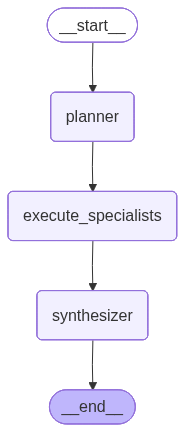

In [293]:
# see graph
from IPython.display import display, Image

Image(guild_graph.get_graph().draw_mermaid_png())

#### Detailed graph

<p align="center">
  <img src="../figures/agent_graph.png" width="1200">
</p>

### Testing our workflow

In [294]:
# This is our high-level request, the initial spark for the entire workflow.
test_request = "Draft inclusion/exclusion criteria for a Phase II trial of 'Sotagliflozin', a novel SGLT2 inhibitor, for adults with uncontrolled Type 2 Diabetes (HbA1c > 8.0%) and moderate chronic kidney disease (CKD Stage 3)."

print("Running the full Guild graph with baseline SOP v1.0...")
# We prepare the initial state for the graph, providing the request and our baseline SOP.
graph_input = {
    "initial_request": test_request,
    "sop": baseline_sop
}
# We invoke the compiled graph with the initial state. LangGraph will now execute the full workflow.
final_result = guild_graph.invoke(graph_input)
# After the graph finishes, we print the final, synthesized output.
print("\nFinal Guild Output:")
print("---------------------")
print(final_result['final_criteria'])

Running the full Guild graph with baseline SOP v1.0...
--- EXECUTING PLANNER AGENT ---
Generated Plan:
{
  "plan": [
    {
      "agent": "Regulatory Specialist",
      "task_description": "Review and ensure compliance with regulatory requirements for Phase II trial of Sotagliflozin in adults with uncontrolled Type 2 Diabetes and moderate CKD Stage 3.",
      "dependencies": []
    },
    {
      "agent": "Medical Researcher",
      "task_description": "Collaborate on drafting inclusion/exclusion criteria for the trial, considering trial objectives, Sotagliflozin mechanism of action, and the specific population of adults with uncontrolled Type 2 Diabetes and moderate CKD Stage 3.",
      "dependencies": [
        "Regulatory Specialist"
      ]
    },
    {
      "agent": "Ethics Specialist",
      "task_description": "Ensure the trial inclusion/exclusion criteria align with relevant ethical guidelines and regulations, particularly those related to vulnerable populations and the use of

### Evaluation

Foe evaluation, we need to move beyond simplistic, single-score metrics like accuracy. The quality of a clinical trial protocol is multi-dimensional. We will now build a sophisticated evaluation suite that is going to measure the Guild output across the five competing pillars we identified at the start. This gauntlet will provide the rich, multi-dimensional feedback signal that is the lifeblood of our evolutionary outer loop.

In this section, here’s what we are going to do:

- Implement LLM-as-a-Judge: We will build three separate evaluators using our most powerful model (llama3:70b) to act as expert judges for the qualitative aspects of Scientific Rigor, Regulatory Compliance, and Ethical Soundness.

- Create Programmatic Evaluators: We will write two fast, reliable, and objective programmatic functions to score the quantitative aspects of Recruitment Feasibility and Operational Simplicity.

- Build the Aggregate Evaluator: Wrapping all five of these individual evaluators into a single, master function that takes the final output of our Guild and generates the 5D performance vector our AI Director will use to make its decisions.

<p align="center">
  <img src="../figures/evaluation.png" width="800">
</p>

First, a small utility: we will define a Pydantic model to ensure the output of our LLM judges is always structured, containing both a numerical score and a textual justification.

In [295]:
from pydantic import BaseModel, Field

class GradedScore(BaseModel):
    """A Pydantic model to structure the output of our LLM-as-a-Judge evaluators."""
    # The score must be a float between 0.0 and 1.0.
    score: float = Field(description="A score from 0.0 to 1.0")
    # The reasoning provides the qualitative justification for the score, which is invaluable for debugging.
    reasoning: str = Field(description="A brief justification for the score.")

output_parser = JsonOutputParser(
        name="evaluator",
        pydantic_object=GradedScore
)

In [296]:
from langchain_core.prompts import ChatPromptTemplate

# Evaluator 1: Scientific Rigor (LLM-as-Judge)
def scientific_rigor_evaluator(generated_criteria: str, pubmed_context: str) -> GradedScore:
    """Evaluates if the generated criteria are scientifically justified by the provided literature."""
    # We use our most powerful 'director' model for this nuanced evaluation task.
    # Make sure to instruct the LLM to format its response according to our Pydantic model.
    evaluator_llm = llm_config['director']
    
    # The prompt gives the LLM a specific persona ("expert clinical scientist") and a clear task.
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an expert clinical scientist. Evaluate a set of clinical trial criteria based on the provided scientific literature. A score of 1.0 means the criteria are perfectly aligned with and justified by the literature. A score of 0.0 means they contradict or ignore the literature.\n\n{format_instructions}"),
        # We provide both the criteria to be judged and the evidence it should be judged against.
        ("human", "Evaluate the following criteria:\n\n**Generated Criteria:**\n{criteria}\n\n**Supporting Scientific Context:**\n{context}")
    ]).partial(format_instructions=output_parser.get_format_instructions())
    
    # We create a simple LangChain Expression Language (LCEL) chain.
    chain = prompt | evaluator_llm | output_parser
    # We invoke the chain with the generated criteria and the context retrieved by the Medical Researcher.
    return chain.invoke({"criteria": generated_criteria, "context": pubmed_context})


In [297]:
# Evaluator 2: Regulatory Compliance (LLM-as-Judge)
def regulatory_compliance_evaluator(generated_criteria: str, fda_context: str) -> GradedScore:
    """Evaluates if the generated criteria adhere to the provided FDA guidelines."""
    evaluator_llm = llm_config['director']
    # This prompt assigns a different persona: "expert regulatory affairs specialist".
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an expert regulatory affairs specialist. Evaluate if a set of clinical trial criteria adheres to the provided FDA guidelines. A score of 1.0 means full compliance.\n\n{format_instructions}"),
        ("human", "Evaluate the following criteria:\n\n**Generated Criteria:**\n{criteria}\n\n**Applicable FDA Guidelines:**\n{context}")
    ]).partial(format_instructions=output_parser.get_format_instructions())
    
    chain = prompt | evaluator_llm | output_parser
    # This time, we invoke the chain with the context retrieved by the Regulatory Specialist.
    return chain.invoke({"criteria": generated_criteria, "context": fda_context})


In [298]:
# Evaluator 3: Ethical Soundness (LLM-as-Judge)
def ethical_soundness_evaluator(generated_criteria: str, ethics_context: str) -> GradedScore:
    """Evaluates if the criteria adhere to the core principles of clinical research ethics."""
    evaluator_llm = llm_config['director']
    # The persona is now an "expert on clinical trial ethics".
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an expert on clinical trial ethics. Evaluate if a set of criteria adheres to the ethical principles provided (summarizing the Belmont Report). A score of 1.0 means the criteria show strong respect for persons, beneficence, and justice.\n\n{format_instructions}"),
        ("human", "Evaluate the following criteria:\n\n**Generated Criteria:**\n{criteria}\n\n**Ethical Principles:**\n{context}")
    ]).partial(format_instructions=output_parser.get_format_instructions())
    
    chain = prompt | evaluator_llm | output_parser
    # We use the context from the Ethics Specialist's retriever.
    return chain.invoke({"criteria": generated_criteria, "context": ethics_context})

Now, we will move on to our programmatic evaluators. Not all metrics require the nuanced reasoning of an LLM. For objective, quantifiable aspects, simple Python functions are faster, cheaper, and 100% reliable. Let’s build the evaluator for Recruitment Feasibility.

In [299]:
# Evaluator 4: Recruitment Feasibility (Programmatic)
def feasibility_evaluator(cohort_analyst_output: AgentOutput) -> GradedScore:
    """Scores feasibility by parsing the patient count from the SQL Analyst's output and normalizing it."""
    # We get the raw text findings from the Patient Cohort Analyst.
    findings_text = cohort_analyst_output.findings
    try:
        # We parse the patient count from the analyst's formatted string.
        count_str = findings_text.split("database: ")[1].replace('.', '')
        patient_count = int(count_str)
    except (IndexError, ValueError):
        # If parsing fails, we return a score of 0.0, as the feasibility is unknown.
        return GradedScore(score=0.0, reasoning="Could not parse patient count from analyst output.")
    
    # We normalize the score against an ideal target. For a Phase II trial, ~150 patients is a reasonable goal.
    IDEAL_COUNT = 150.0
    # The score is the ratio of found patients to the ideal count, capped at 1.0.
    score = min(1.0, patient_count / IDEAL_COUNT)
    reasoning = f"Estimated {patient_count} eligible patients. Score is normalized against an ideal target of {int(IDEAL_COUNT)}."
    return GradedScore(score=score, reasoning=reasoning)

In [300]:
# Evaluator 5: Operational Simplicity (Programmatic)
def simplicity_evaluator(generated_criteria: str) -> GradedScore:
    """Scores simplicity by penalizing the inclusion of expensive or complex screening tests."""
    # We define a list of keywords for tests that add significant cost and complexity to patient screening.
    EXPENSIVE_TESTS = ["mri", "genetic sequencing", "pet scan", "biopsy", "echocardiogram", "endoscopy"]
    
    # We count how many of these keywords appear in the generated criteria (case-insensitive).
    test_count = sum(1 for test in EXPENSIVE_TESTS if test in generated_criteria.lower())
    
    # The score starts at 1.0 and is penalized by 0.5 for each expensive test found.
    score = max(0.0, 1.0 - (test_count * 0.5))
    reasoning = f"Found {test_count} expensive/complex screening procedures mentioned."
    return GradedScore(score=score, reasoning=reasoning)

The simplicity_evaluator is a simple but effective heuristic for estimating operational cost. It acts as a "red flag" system. By scanning for keywords related to expensive procedures, it provides a penalty for criteria that might be scientifically sound but impractical to implement on a large scale. This provides another crucial, real-world constraint for our optimization problem.

<p align="center">
  <img src="../figures/aggregate_evaluator.png" width="1000">
</p>

In [301]:
class EvaluationResult(BaseModel):
    """A Pydantic model to hold the complete 5D evaluation result."""
    rigor: GradedScore
    compliance: GradedScore
    ethics: GradedScore
    feasibility: GradedScore
    simplicity: GradedScore

In [302]:
def run_full_evaluation(guild_final_state: GuildState) -> EvaluationResult:
    """Orchestrates the entire evaluation process, calling each of the five specialist evaluators."""
    print("--- RUNNING FULL EVALUATION GAUNTLET ---")
    
    # Extract the necessary pieces of information from the final state of the Guild graph.
    final_criteria = guild_final_state['final_criteria']
    agent_outputs = guild_final_state['agent_outputs']
    
    # We need to find the specific findings from each specialist to pass to the correct evaluator.
    # We use next() with a default value to safely handle cases where an agent might not have run.
    pubmed_context = next((o.findings for o in agent_outputs if o.agent_name == "Medical Researcher"), "")
    fda_context = next((o.findings for o in agent_outputs if o.agent_name == "Regulatory Specialist"), "")
    ethics_context = next((o.findings for o in agent_outputs if o.agent_name == "Ethics Specialist"), "")
    analyst_output = next((o for o in agent_outputs if o.agent_name == "Patient Cohort Analyst"), None)
    
    # We now call each of our five evaluator functions in sequence.
    print("Evaluating: Scientific Rigor...")
    rigor = scientific_rigor_evaluator(final_criteria, pubmed_context)
    print("Evaluating: Regulatory Compliance...")
    compliance = regulatory_compliance_evaluator(final_criteria, fda_context)
    print("Evaluating: Ethical Soundness...")
    ethics = ethical_soundness_evaluator(final_criteria, ethics_context)
    print("Evaluating: Recruitment Feasibility...")
    feasibility = feasibility_evaluator(analyst_output) if analyst_output else GradedScore(score=0, reasoning="Analyst did not run.")
    print("Evaluating: Operational Simplicity...")
    simplicity = simplicity_evaluator(final_criteria)
    
    print("--- EVALUATION GAUNTLET COMPLETE ---")
    # Finally, we package all the results into our EvaluationResult model.
    return EvaluationResult(rigor=rigor, compliance=compliance, ethics=ethics, feasibility=feasibility, simplicity=simplicity)


In [303]:
# 'final_result' is the variable holding the final state from our test run in section 2.4.
baseline_evaluation_result = run_full_evaluation(final_result)

print("\nFull Evaluation Result for Baseline SOP:")
# We use .dict() to get a dictionary representation of the Pydantic model for pretty printing.
print(json.dumps(baseline_evaluation_result.model_dump(), indent=4))

--- RUNNING FULL EVALUATION GAUNTLET ---
Evaluating: Scientific Rigor...
Evaluating: Regulatory Compliance...
Evaluating: Ethical Soundness...
Evaluating: Recruitment Feasibility...
Evaluating: Operational Simplicity...
--- EVALUATION GAUNTLET COMPLETE ---

Full Evaluation Result for Baseline SOP:
{
    "rigor": {
        "score": 0.9,
        "reasoning": "The inclusion and exclusion criteria align with the scientific literature, with a focus on patients with type 2 diabetes and stage 3a/3b chronic kidney disease. The criteria incorporate relevant factors such as glycemic control, renal function, and medication regimen. However, some exclusion criteria, such as the history of major protocol violations, may not be directly supported by the provided literature, which reduces the score to 0.9."
    },
    "compliance": {
        "score": 0.86,
        "reasoning": "The inclusion and exclusion criteria adhere to the FDA guidelines for diabetes studies, with clear definitions for patient p

### Checking feasability issues

There might be an SQL error

In [275]:
for a in final_result["agent_outputs"]:
    if a.agent_name == "Patient Cohort Analyst":
        print(a.findings)

Generated SQL Query:

SELECT COUNT(DISTINCT p.SUBJECT_ID) 
FROM PATIENTS p
JOIN DIAGNOSES_ICD di ON p.SUBJECT_ID = CAST(di.SUBJECT_ID AS BIGINT)
JOIN LABEVENTS le1 ON p.SUBJECT_ID = CAST(le1.SUBJECT_ID AS BIGINT)
JOIN LABEVENTS le2 ON p.SUBJECT_ID = CAST(le2.SUBJECT_ID AS BIGINT)
WHERE di.ICD9_CODE = '25000'
AND le1.ITEMID = 50912
AND le1.VALUENUM >= 1.5
AND le1.VALUENUM <= 3.0
AND le2.ITEMID = 50852
AND le2.VALUENUM > 8.0


Estimated eligible patient count from the database: 1.


This is the precise, actionable, multi-dimensional feedback our AI Research Director needs. It has not just been told the output is “bad”, it has been told exactly which dimension is failing and why. The stage is now perfectly set for next part, where the Director will analyze this very report and attempt to evolve the SOP to fix this specific feasibility problem.

Now, we are going to build the brain of our self-improving system: the “AI Research Director”. This is our “Outer Loop”. It’s a higher-level agentic system whose job is not to design clinical trials, but to improve the process of designing clinical trials.

It will analyze the 5D performance vector from our evaluation gauntlet, diagnose the root cause of any weaknesses, and intelligently rewrite the Guild’s own GuildSOP to address them. This is where we implement the core evolutionary concepts that allow our system to learn and adapt.

Now, we do the following:

- Create the Gene Pool: We will build a simple class to store and manage our evolving SOPs and their performance scores, creating a “gene pool” of process configurations.

- Design the Director-Level Agents: We will implement the two core agents of the Director: the Performance Diagnostician, which identifies weaknesses, and the SOP Architect, which proposes solutions.

- Architect the Evolutionary Loop: Then define a master function that orchestrates a single, complete generation of evolution: Diagnose -> Evolve -> Evaluate.

- Run a Full Evolution Cycle: Going to execute this loop to show the system autonomously identifying the feasibility weakness in our baseline SOP and generating new, mutated SOPs to try and fix it.

### Managing Guild Configurations

In [304]:
class SOPGenePool:
    """A simple class to store and manage a collection of GuildSOPs and their evaluations, acting as our 'gene pool'."""
    def __init__(self):
        # The pool will be a list of dictionaries, each holding an SOP, its evaluation, and metadata.
        self.pool: List[Dict[str, Any]] = []
        # A simple counter to assign a unique version number to each new SOP.
        self.version_counter = 0

    def add(self, sop: GuildSOP, eval_result: EvaluationResult, parent_version: Optional[int] = None):
        """Adds a new SOP and its evaluation result to the pool."""
        self.version_counter += 1
        entry = {
            "version": self.version_counter,
            "sop": sop,
            "evaluation": eval_result,
            "parent": parent_version # Tracking the parent is key for analyzing evolutionary paths.
        }
        self.pool.append(entry)
        print(f"Added SOP v{self.version_counter} to the gene pool.")
        
    def get_latest_entry(self) -> Optional[Dict[str, Any]]:
        """A convenience method to retrieve the most recently added entry."""
        return self.pool[-1] if self.pool else None


### Building The Director-Level Agents

Now we define the two agents that form the core of our evolution engine. These agents operate at a higher level of abstraction. They don’t reason about medicine or regulations, they reason about process and performance.

<p align="center">
  <img src="../figures/director_level_agents.png" width="600">
</p>

In [305]:
class Diagnosis(BaseModel):
    """A Pydantic model for the structured output of the Diagnostician agent."""
    # The primary weakness must be one of the five pillars.
    primary_weakness: Literal['rigor', 'compliance', 'ethics', 'feasibility', 'simplicity']
    # A detailed analysis of why the weakness occurred, grounding its reasoning in the specific scores.
    root_cause_analysis: str = Field(description="A detailed analysis of why the weakness occurred, referencing specific scores.")
    # A high-level, strategic recommendation for how to fix the problem.
    recommendation: str = Field(description="A high-level recommendation for how to modify the SOP to address the weakness.")


def performance_diagnostician(eval_result: EvaluationResult) -> Diagnosis:
    """Analyzes the 5D evaluation vector and diagnoses the primary weakness."""
    print("--- EXECUTING PERFORMANCE DIAGNOSTICIAN ---")
    # We use our most powerful 'director' model (Llama 3 70B) for this critical reasoning task.
    diagnostician_llm = llm_config['director']

    dir_output_parser = JsonOutputParser(
        name="dir_parser",
        pydantic_object=Diagnosis
    )
    # The prompt assigns the persona of a management consultant specializing in process optimization.
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a world-class management consultant specializing in process optimization. Your task is to analyze a performance scorecard and identify the single biggest weakness. Then, provide a root cause analysis and a strategic recommendation.\n\n{format_instructions}"),
        ("human", "Please analyze the following performance evaluation report:\n\n{report}")
    ]).partial(format_instructions=dir_output_parser.get_format_instructions())
    
    chain = prompt | diagnostician_llm | dir_output_parser
    # We invoke the chain with the JSON representation of the full evaluation result.
    return chain.invoke({"report": eval_result.model_dump_json()})

The second agent is the SOP Architect. This agent is the evolver, It takes the diagnosis from the previous step and the current GuildSOP, and its job is to generate several new, mutated versions of the SOP, each representing a different strategy to solve the identified problem.

In [306]:
class EvolvedSOPs(BaseModel):
    """A Pydantic container for a list of new, evolved GuildSOPs."""
    mutations: List[GuildSOP]

def sop_architect(diagnosis: Diagnosis, current_sop: GuildSOP) -> EvolvedSOPs:
    """Takes a diagnosis and the current SOP, and generates a list of new, mutated SOPs to test."""
    print("--- EXECUTING SOP ARCHITECT ---")
    # We again use our powerful 'director' model, this time configured to output a list of GuildSOP objects.
    architect_llm = llm_config['director']
    evolver_output_parser = JsonOutputParser(
        name="evolver_parser",
        pydantic_object=EvolvedSOPs
    )

    # This prompt is highly specific. It tells the agent its job is to modify a JSON object (the SOP)
    # to fix a specific problem. We even provide the JSON schema of the SOP in the prompt for context.
    schema_str = json.dumps(GuildSOP.model_json_schema()).replace("{", "{{").replace("}", "}}")
    prompt = ChatPromptTemplate.from_messages([
    ("system", 
     "You are an AI process architect. Your job is to modify a process configuration (an SOP) to fix a diagnosed problem. "
     f"The SOP is a JSON object with this schema: {schema_str}. "
     "You must return a list of 2-3 new, valid SOP JSON objects under the 'mutations' key. "
     "Propose diverse and creative mutations. For example, you can change prompts, toggle agents, change retrieval parameters, "
     "or even change the model used for a task. Only modify fields relevant to the diagnosis.\n\n"
     "{format_instructions}"),  
    ("human", 
     "Here is the current SOP:\n{current_sop}\n\n"
     "Here is the performance diagnosis:\n{diagnosis}\n\n"
     "Based on the diagnosis, please generate 2-3 new, improved SOPs.")
    ]).partial(format_instructions=evolver_output_parser.get_format_instructions())
    
    chain = prompt | architect_llm | evolver_output_parser
    return chain.invoke({
    "current_sop": json.dumps(current_sop) if isinstance(current_sop, dict) else current_sop.model_dump_json(),
    "diagnosis": json.dumps(diagnosis) if isinstance(diagnosis, dict) else diagnosis.model_dump_json(),
    })

1. The sop_architect is the creative engine of our self-improving system. Its prompt is a kind of instruction engineering. We are telling the LLM: "You are a programmer. Here is the source code (current_sop). Here is the bug report (diagnosis). Now, write 2-3 different patches (mutations) to try and fix the bug".

2. By providing the GuildSOP.schema_json() directly in the prompt, we drastically increase the likelihood that the LLM will generate valid, correctly formatted new SOPs. This agent doesn't just randomly change things; it proposes targeted, intelligent modifications based on the specific problem identified by the diagnostician.

We can now wrap these into a master function that orchestrates one full cycle of Diagnose -> Evolve -> Evaluate.

In [307]:
def run_evolution_cycle(gene_pool: SOPGenePool, trial_request: str):
    """Runs one full cycle of diagnosis, mutation, and re-evaluation."""
    print("\n" + "="*25 + " STARTING NEW EVOLUTION CYCLE " + "="*25)
    
    # Step 1: Select the current best SOP to improve upon. For simplicity, we'll just take the latest one added to the pool.
    current_best_entry = gene_pool.get_latest_entry()
    parent_sop = current_best_entry['sop']
    parent_eval = current_best_entry['evaluation']
    parent_version = current_best_entry['version']
    print(f"Improving upon SOP v{parent_version}...")
    
    # Step 2: Diagnose the performance of the parent SOP.
    diagnosis = performance_diagnostician(parent_eval)
    print(f"Diagnosis complete. Primary Weakness: '{diagnosis["primary_weakness"]}'. Recommendation: {diagnosis["recommendation"]}")

    # Step 3: Architect new SOP candidates based on the diagnosis.
    new_sop_candidates = sop_architect(diagnosis, parent_sop)
    print(f"Generated {len(new_sop_candidates["mutations"])} new SOP candidates.")
    # Step 4: Evaluate each new candidate by running the full Guild graph and the evaluation gauntlet.
    for i, candidate_sop in enumerate(new_sop_candidates["mutations"]):
        print(f"\n--- Testing SOP candidate {i+1}/{len(new_sop_candidates["mutations"])} ---")
        print(candidate_sop)
        # We run the entire inner loop (the Guild) with the new, mutated SOP.
        guild_input = {"initial_request": trial_request, "sop": GuildSOP(**candidate_sop)}
        final_state = guild_graph.invoke(guild_input)
        
        # We then run our full evaluation gauntlet on the output.
        eval_result = run_full_evaluation(final_state)
        # Finally, we add the new SOP and its performance to our gene pool.
        gene_pool.add(sop=candidate_sop, eval_result=eval_result, parent_version=parent_version)
    print("\n" + "="*25 + " EVOLUTION CYCLE COMPLETE " + "="*26)


Let’s put it all together. We will initialize our SOPGenePool, add our baseline SOP and its evaluation result, and then run a single evolution cycle.

In [308]:
# Initialize our gene pool.
gene_pool = SOPGenePool()
print("Initialized SOP Gene Pool.")

# Add our baseline SOP (v1) and its previously calculated evaluation as the first entry.
gene_pool.add(sop=baseline_sop, eval_result=baseline_evaluation_result)
# Now, we execute one full cycle of evolution, starting from our baseline.
run_evolution_cycle(gene_pool, test_request)

Initialized SOP Gene Pool.
Added SOP v1 to the gene pool.

========================= STARTING NEW EVOLUTION CYCLE =========================
Improving upon SOP v1...
--- EXECUTING PERFORMANCE DIAGNOSTICIAN ---
Diagnosis complete. Primary Weakness: 'feasibility'. Recommendation: Revise the inclusion and exclusion criteria to increase the potential pool of eligible patients, and explore alternative recruitment strategies to improve feasibility and reach the ideal target of 150 patients.
--- EXECUTING SOP ARCHITECT ---
Generated 3 new SOP candidates.

--- Testing SOP candidate 1/3 ---
{'planner_prompt': "You are a master planner for clinical trial design. Your task is to receive a high-level trial concept and break it down into a structured plan with specific sub-tasks for a team of specialists: a Regulatory Specialist, a Medical Researcher, an Ethics Specialist, and a Patient Cohort Analyst. Output a JSON object with a single key 'plan' containing a list of tasks. Each task must have 'age

ValidationError: 1 validation error for GuildSOP
synthesizer_prompt
  Field required [type=missing, input_value={'planner_prompt': 'You are a'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing

In this final section, here’s what we are going to do:

- Analyze the Gene Pool: We will first print a summary of all the SOPs and their performance scores to see the direct impact of the mutations.

- Identify the Pareto Front: We will write a function to programmatically identify the non-dominated solutions in our gene pool the set of SOPs that represent the best possible trade-offs.

- Visualize the Frontier: Create a powerful visualization, a parallel coordinates plot, that allows us to see the performance of our optimal SOPs across all five dimensions simultaneously, making the trade-offs clear and intuitive.

In [309]:
# We'll iterate through our gene pool and print a formatted summary of each entry's performance.
print("SOP Gene Pool Evaluation Summary:")
print("---------------------------------")
for entry in gene_pool.pool:
    v = entry['version']
    p = entry['parent']
    evals = entry['evaluation']
    # Extract the score from each GradedScore object.
    r, c, e, f, s = evals.rigor.score, evals.compliance.score, evals.ethics.score, evals.feasibility.score, evals.simplicity.score
    parent_str = f"(Parent)" if p is None else f"(Child of v{p})"
    print(f"SOP v{v:<2} {parent_str:<14}: Rigor={r:.2f}, Compliance={c:.2f}, Ethics={e:.2f}, Feasibility={f:.2f}, Simplicity={s:.2f}")

SOP Gene Pool Evaluation Summary:
---------------------------------
SOP v1  (Parent)      : Rigor=0.90, Compliance=0.86, Ethics=0.90, Feasibility=0.01, Simplicity=1.00
SOP v2  (Child of v1) : Rigor=0.90, Compliance=0.90, Ethics=0.80, Feasibility=0.01, Simplicity=1.00
SOP v3  (Child of v1) : Rigor=0.70, Compliance=0.90, Ethics=0.90, Feasibility=0.00, Simplicity=0.50


### Identifying the Pareto Front

Now, we need to formalize the concept of an “optimal trade-off”. In our gene pool, some solutions might be strictly worse than others. For example, SOP v3 has the same scores as SOP v1 on four metrics and is equal on feasibility. There’s no reason to ever choose v3. We say that v3 is “dominated” by v1.

The Pareto Front is the set of all non-dominated solutions. We’ll write a function to identify this set from our gene pool.

In [310]:
import numpy as np

def identify_pareto_front(gene_pool: SOPGenePool) -> List[Dict[str, Any]]:
    """Identifies the non-dominated solutions (the Pareto Front) in the gene pool."""
    pareto_front = []
    pool_entries = gene_pool.pool
    
    # We compare every solution against every other solution.
    for i, candidate in enumerate(pool_entries):
        is_dominated = False
        # Get the 5D score vector for the candidate.
        cand_scores = np.array([s['score'] for s in candidate['evaluation'].model_dump().values()])
        
        for j, other in enumerate(pool_entries):
            if i == j: continue # Don't compare a solution to itself.
            # Get the 5D score vector for the other solution.
            other_scores = np.array([s['score'] for s in other['evaluation'].model_dump().values()])
            
            # The domination condition: 'other' dominates 'candidate' if it is better or equal on ALL scores,
            # AND it is strictly better on AT LEAST ONE score.
            if np.all(other_scores >= cand_scores) and np.any(other_scores > cand_scores):
                is_dominated = True
                break # We can stop checking as soon as we find one solution that dominates it.
        
        # If, after checking all other solutions, none dominated our candidate, it's on the Pareto Front.
        if not is_dominated:
            pareto_front.append(candidate)
            
    return pareto_front

The identify_pareto_front function is a classic implementation of a Pareto dominance check. It's a brute-force but effective algorithm that systematically compares each SOP's 5D performance vector against every other SOP's vector. The logic np.all(other_scores >= cand_scores) and np.any(other_scores > cand_scores) is the formal mathematical definition of Pareto dominance. This function will distill our entire gene pool down to only the most rational, optimal choices.

In [311]:
# Run the function to identify the optimal SOPs.
pareto_sops = identify_pareto_front(gene_pool)

print("SOPs on the Pareto Front:")
print("-------------------------")
for entry in pareto_sops:
    v = entry['version']
    evals = entry['evaluation']
    r, c, e, f, s = evals.rigor.score, evals.compliance.score, evals.ethics.score, evals.feasibility.score, evals.simplicity.score
    print(f"SOP v{v}: Rigor={r:.2f}, Compliance={c:.2f}, Ethics={e:.2f}, Feasibility={f:.2f}, Simplicity={s:.2f}")


SOPs on the Pareto Front:
-------------------------
SOP v1: Rigor=0.90, Compliance=0.86, Ethics=0.90, Feasibility=0.01, Simplicity=1.00
SOP v2: Rigor=0.90, Compliance=0.90, Ethics=0.80, Feasibility=0.01, Simplicity=1.00
SOP v3: Rigor=0.70, Compliance=0.90, Ethics=0.90, Feasibility=0.00, Simplicity=0.50


This is the final, distilled output of our entire system. It doesn’t give us a single “best” answer. Instead, it presents a human decision-maker with a menu of optimal, but different, strategies.

### Visualizing the Frontier & Making a Decision

Visualizing a 5-dimensional space is impossible. However, there are techniques for showing high-dimensional trade-offs. One of the best is the parallel coordinates plot. This plot draws each of our SOPs as a line, with each vertical axis representing one of our five performance pillars. It allows us to instantly see how each strategy performs across all dimensions and where the trade-offs lie.

In [314]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_frontier(pareto_sops):
    """Creates a 2D scatter plot and a parallel coordinates plot to visualize the Pareto front."""
    if not pareto_sops:
        print("No SOPs on the Pareto front to visualize.")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # --- Plot 1: 2D Scatter Plot (Rigor vs. Feasibility) ---
    labels = [f"v{s['version']}" for s in pareto_sops]
    rigor_scores = [s['evaluation'].rigor.score for s in pareto_sops]
    feasibility_scores = [s['evaluation'].feasibility.score for s in pareto_sops]
    
    ax1.scatter(rigor_scores, feasibility_scores, s=200, alpha=0.7, c='blue')
    for i, txt in enumerate(labels):
        ax1.annotate(txt, (rigor_scores[i], feasibility_scores[i]), xytext=(10,-10), textcoords='offset points', fontsize=14)
    ax1.set_title('Pareto Frontier: Rigor vs. Feasibility', fontsize=16)
    ax1.set_xlabel('Scientific Rigor Score', fontsize=14)
    ax1.set_ylabel('Recruitment Feasibility Score', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_xlim(min(rigor_scores)-0.05, max(rigor_scores)+0.05)
    ax1.set_ylim(min(feasibility_scores)-0.1, max(feasibility_scores)+0.1)

    # --- Plot 2: Parallel Coordinates Plot for 5D Analysis ---
    data = []
    for s in pareto_sops:
        eval_dict = s['evaluation'].model_dump()
        scores = {k.capitalize(): v['score'] for k, v in eval_dict.items()}
        scores['SOP Version'] = f"v{s['version']}"
        data.append(scores)
    
    df = pd.DataFrame(data)

    # Fixed: axvlines_kwds (not axvlines_kwargs)
    pd.plotting.parallel_coordinates(df, 'SOP Version', colormap=plt.get_cmap("viridis"), ax=ax2, axvlines_kwds={"linewidth": 1, "color": "grey"})
    ax2.set_title('5D Performance Trade-offs on Pareto Front', fontsize=16)
    ax2.grid(True, which='major', axis='y', linestyle='--', alpha=0.6)
    ax2.set_ylabel('Normalized Score', fontsize=14)
    ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels))
    plt.tight_layout()
    plt.show()

This visualize_frontier function is our final reporting tool. It takes the list of optimal pareto_sops and creates two powerful visualizations. 

The scatter plot provides a classic view of the two-dimensional trade-off between our most conflicting objectives.

The parallel coordinates plot is the main key, it displays the full 5D performance profile of each optimal SOP, allowing a human decision-maker to see the complete picture at a glance.

Let’s run the visualization on our identified Pareto front.

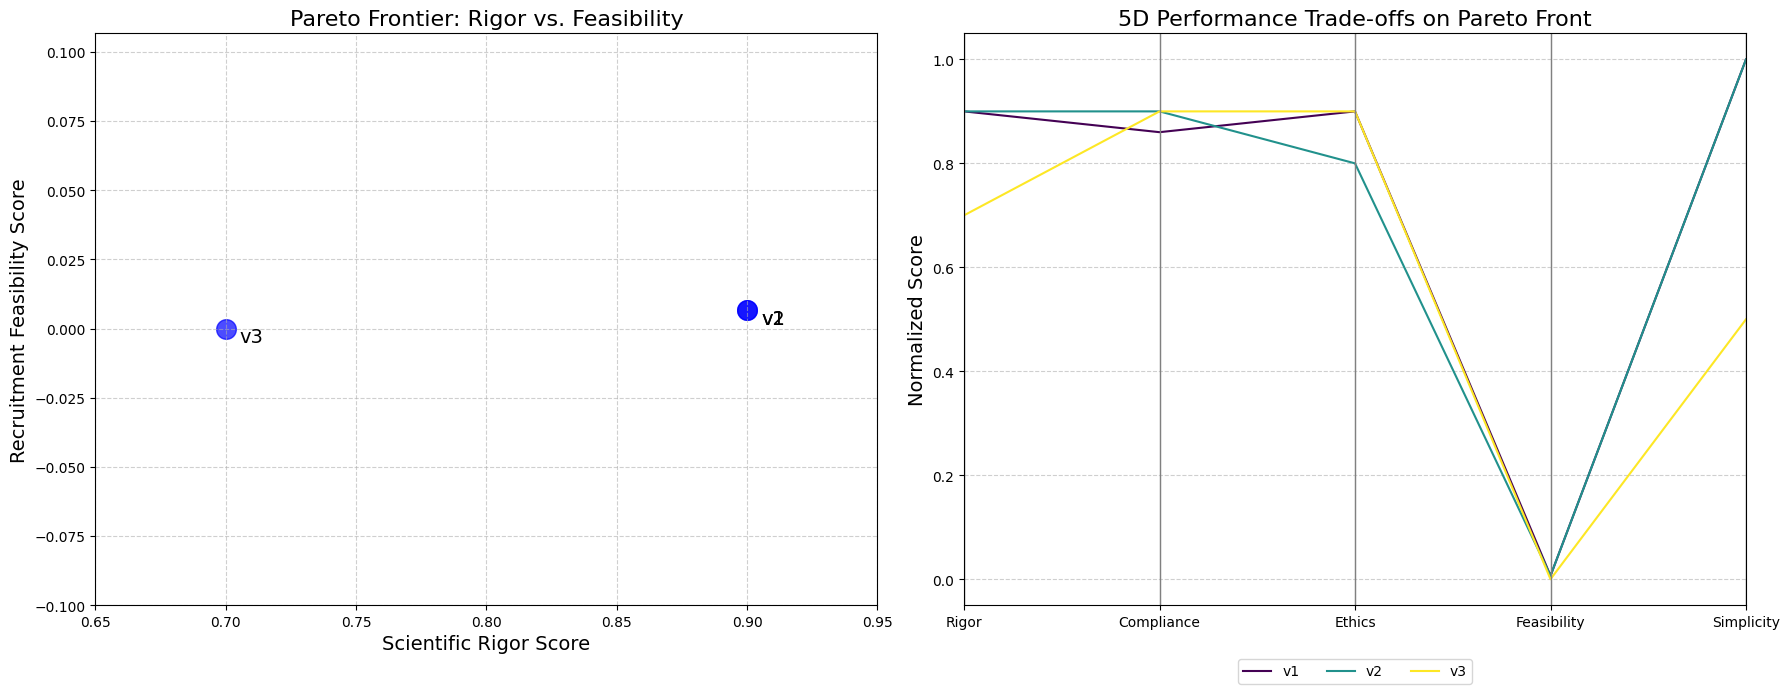

In [315]:
# The output of this cell will be the Matplotlib plot showing our two visualizations.
visualize_frontier(pareto_sops)

### Deeper Analysis

Here’s what we are going to do:

- Instrument the Workflow: We will create a new invocation function that precisely measures the start time, end time, and duration of each agent’s execution within the LangGraph.

- Visualize the Execution Timeline: We will use this timing data to generate a Gantt chart, providing a clear and intuitive visualization of the Guild’s workflow, highlighting both parallel and sequential operations.

- Profile the Performance Vector: We will create a Radar Chart to visualize the 5D performance vector of our baseline and improved SOPs, making the multi-objective trade-offs immediately apparent.

### Visualizing the Agentic Workflow Timeline

First, we want to understand the process of the Guild’s collaboration. 

**Is it truly parallel?**
**Which agent is the bottleneck?**

 To find out, we need to instrument our graph execution to capture timing information for each node.

We will write a new wrapper function, invoke_with_timing, that uses the .stream() method of our compiled graph. The stream() method is a powerful feature that yields the output of each node as it completes. By recording the timestamp before and after each node's execution, we can capture the raw data needed to build a timeline.

**You can also just see all time taken in the langsmith monitoring as well**

In [324]:
import time

def invoke_with_timing(graph, sop, request):
    """Invokes the Guild graph while capturing timing for each node."""
    print(f"--- Instrumenting Graph Run for SOP: {sop.model_dump()} ---")
    
    timing_data = []
    graph_input = {"initial_request": request, "sop": sop}
    
    last_time = time.time()
    final_state = None
    
    for event in graph.stream(graph_input, stream_mode="updates"):
        current_time = time.time()
        
        for node_name, node_output in event.items():
            # Duration is time since last event (i.e., how long this node took)
            duration = current_time - last_time
            
            timing_data.append({
                "node": node_name,
                "start_time": last_time,  # When the node started (end of previous)
                "end_time": current_time,  # When the node finished
                "duration": duration
            })
            final_state = node_output
        
        # Update last_time AFTER processing the event
        last_time = current_time
    
    # Normalize to start from 0
    if timing_data:
        overall_start = timing_data[0]['start_time']
        for data in timing_data:
            data['start_time'] -= overall_start
            data['end_time'] -= overall_start
    
    return final_state, timing_data

In [325]:
# We'll use the second entry from our gene pool, which is the successful SOP v2.
sop_v2 = GuildSOP(**gene_pool.pool[1]['sop'])
final_state_v2, timing_data_v2 = invoke_with_timing(guild_graph, sop_v2, test_request)

print("\n--- Captured Timing Data for SOP v2 ---")
print(json.dumps(timing_data_v2, indent=2))

--- Instrumenting Graph Run for SOP: {'planner_prompt': "You are a master planner for clinical trial design. Your task is to receive a high-level trial concept and break it down into a structured plan with specific sub-tasks for a team of specialists: a Regulatory Specialist, a Medical Researcher, an Ethics Specialist, and a Patient Cohort Analyst. Output a JSON object with a single key 'plan' containing a list of tasks. Each task must have 'agent', 'task_description', and 'dependencies' keys. Consider revising the inclusion and exclusion criteria to increase the potential pool of eligible patients and explore alternative recruitment strategies to improve feasibility.", 'researcher_retriever_k': 5, 'synthesizer_prompt': "You are an expert medical writer. Your task is to synthesize the structured findings from all specialist teams into a formal 'Inclusion and Exclusion Criteria' document. Be concise, precise, and adhere strictly to the information provided. Structure your output into tw

Now, we will write a function to take this timing data and plot it as a Gantt chart. This will give us an immediate, visual understanding of the workflow’s timeline.

In [326]:
import matplotlib.pyplot as plt

def plot_gantt_chart(timing_data: List[Dict[str, Any]], title: str):
    """Plots a Gantt chart of the agentic workflow from timing data."""
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Get the names of the nodes for our y-axis labels.
    labels = [d['node'] for d in timing_data]
    
    # The core of the Gantt chart: a horizontal bar plot.
    # The 'left' parameter sets the start time of the bar.
    ax.barh(labels, [d['duration'] for d in timing_data], left=[d['start_time'] for d in timing_data], color='skyblue')
    
    ax.set_xlabel('Time (seconds)')
    ax.set_title(title, fontsize=16)
    ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.6)
    
    # Invert the y-axis so the first task is at the top.
    ax.invert_yaxis()
    plt.show()

This plot_gantt_chart function is a standard Matplotlib plotting utility. It takes our list of timing data dictionaries and uses ax.barh to create horizontal bars. The key is the left parameter, which offsets each bar to its correct start time, and the width of the bar, which is set to its duration. This simple technique is all that's needed to transform our numerical data into an intuitive timeline.

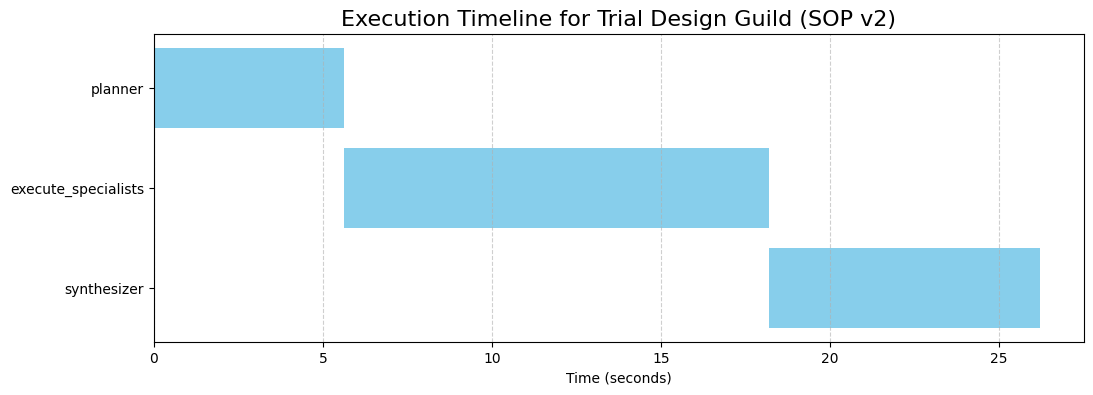

In [327]:
plot_gantt_chart(timing_data_v2, "Execution Timeline for Trial Design Guild (SOP v2)")

### Profiling the Output with a Radar Chart


The Gantt chart showed us the performance of the process. Now, let’s visualize the performance of the outcome. Our evaluation system produces a 5D vector of scores. A simple table of numbers is hard to interpret. A Radar Chart (or Spider Plot) is a perfect tool for this, as it can map a multi-dimensional profile onto an intuitive, 2D shape.

In [350]:
import pandas as pd


def plot_radar_chart(eval_results: List[Dict[str, Any]], labels: List[str]):
    """Creates a radar chart to compare the 5D performance of multiple SOPs."""
    
    # The categories for our radar chart axes are the five pillars of quality.
    categories = ['Rigor', 'Compliance', 'Ethics', 'Feasibility', 'Simplicity']
    num_vars = len(categories)
    # We calculate the angle for each axis on the plot.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # The plot needs to be a closed loop, so we repeat the first angle at the end.
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    # Plot each SOP's performance as a separate line/shape on the radar.
    for i, result in enumerate(eval_results):
        # Extract the scores and repeat the first score at the end to close the shape.
        values = [res["score"] for res in result.model_dump().values()]
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i])
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_title('5D Performance Profile Comparison', size=20, color='blue', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

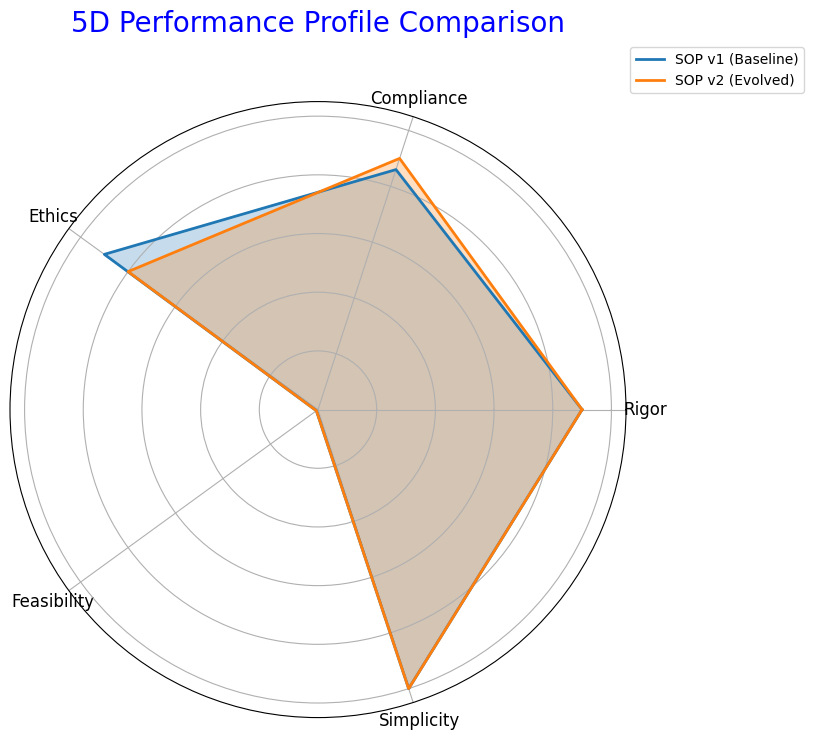

In [351]:
# We gather the evaluation results for SOP v1 and SOP v2 from our gene pool.
evals_to_plot = [
    gene_pool.pool[0]['evaluation'], # SOP v1
    gene_pool.pool[1]['evaluation']  # SOP v2
]
labels_for_plot = ['SOP v1 (Baseline)', 'SOP v2 (Evolved)']

plot_radar_chart(evals_to_plot, labels_for_plot)